# Momentum investing trading strategy


Momentum investing is a trading method in which investors purchase increasing securities and sell them when they appear to have peaked.

The idea is to work with volatility by looking for purchasing opportunities in short-term uptrends and selling when the stocks begin to lose momentum.

The investor then takes the cash and seeks for the next short-term uptrend or purchasing opportunity, and the process is repeated.

Competent traders know when to start a position, when to hold it, and when to quit it; they can also react to short-term, news-driven spikes or selloffs.

**Momentum trading risks** include moving into a position too early, closing out too late, and becoming preoccupied and missing significant trends and technical deviations.

In [ ]:
!pip install mpl_finance
!pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

In [2]:
import numpy as np, pandas as pd
# dataloader
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# date
import datetime as dt
import matplotlib.dates as mdates
# stats
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
# visualization
from mpl_finance import candlestick_ohlc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('figure', figsize=(16, 6))

In [3]:
# GLD - TSLA, Inc.- 
ticker = 'GLD'
start = dt.datetime(2018, 1, 1)
end = dt.datetime.today()

df = pdr.get_data_yahoo(ticker, start, end)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-27,168.880005,169.229996,168.550003,169.009995,169.009995,4509200
2023-02-28,168.779999,170.250000,168.589996,169.779999,169.779999,6761600
2023-03-01,170.949997,171.490005,170.470001,170.759995,170.759995,6590500
2023-03-02,170.520004,170.979996,170.360001,170.660004,170.660004,3952300
2023-03-03,171.449997,172.589996,170.979996,172.490005,172.490005,6272111


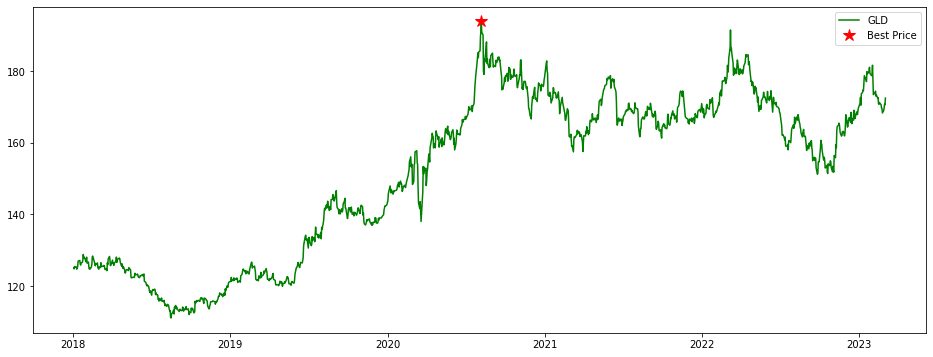

In [4]:
plt.plot(df['Close'], color = 'g', label = 'GLD')
plt.plot(df.loc[df.Close == max(df['Close'])].index, max(df['Close']), '*', color = 'r', markersize = 12, label='Best Price')
plt.legend()

## Moving Averages (9 and 21 days)

In [5]:
df['9-day'] = df['Close'].rolling(9).mean()
df['21-day'] = df['Close'].rolling(21).mean()

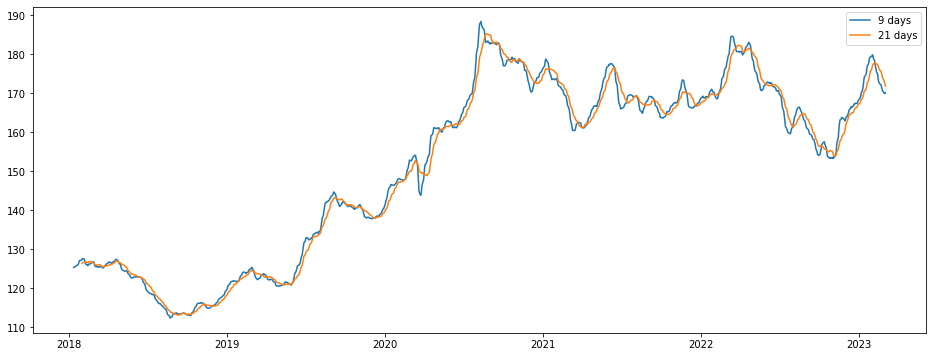

In [6]:
plt.plot(df['9-day'], label='9 days')
plt.plot(df['21-day'], label='21 days')
plt.legend();

## Signal (When to trade long or short)

    if moving moving avg(9-days) > moving avg(21-days) then signal=1
    else: -1

In [7]:
print(f"Length of data before: {len(df)}")
df.dropna(inplace=True)
print(f"Length of data after: {len(df)}")

Length of data before: 1301
Length of data after: 1281


In [8]:
# 1: Long, -1 Short
df['signal'] = np.where(df['9-day'] > df['21-day'], 1, -1)
df.head()

,Open,High,Low,Close,Adj Close,Volume,9-day,21-day,signal
Date,,,,,,,,,
2018-01-31,127.449997,127.849998,126.400002,127.650002,127.650002,13418900,127.446668,126.400953,1
2018-02-01,127.180000,128.149994,127.080002,128.070007,128.070007,10854600,127.630002,126.540001,1
2018-02-02,126.809998,126.849998,125.959999,126.389999,126.389999,16789200,127.601113,126.614763,1
2018-02-05,126.820000,127.309998,126.440002,126.709999,126.709999,13596300,127.537780,126.674287,1
2018-02-06,126.540001,126.550003,125.220001,125.379997,125.379997,17672500,127.154446,126.676667,1


In [9]:
df.signal.value_counts()

 1    693
-1    588
Name: signal, dtype: int64

## Perfect Entry Timing

The best momentum trades occur when a news shock occurs, triggering fast movement from one price level to the next. As a result, alert players receive buying or selling signals and are rewarded with instant profits.

In [10]:
df['entry'] = df.signal.diff()
df.tail()

,Open,High,Low,Close,Adj Close,Volume,9-day,21-day,signal,entry
Date,,,,,,,,,,
2023-02-27,168.880005,169.229996,168.550003,169.009995,169.009995,4509200,170.302222,173.534286,-1,0.0
2023-02-28,168.779999,170.250000,168.589996,169.779999,169.779999,6761600,169.987778,173.084762,-1,0.0
2023-03-01,170.949997,171.490005,170.470001,170.759995,170.759995,6590500,169.973333,172.703809,-1,0.0
2023-03-02,170.520004,170.979996,170.360001,170.660004,170.660004,3952300,169.963333,172.287143,-1,0.0
2023-03-03,171.449997,172.589996,170.979996,172.490005,172.490005,6272111,170.100001,171.850000,-1,0.0


In [11]:
df.entry.value_counts()

 0.0    1213
-2.0      34
 2.0      33
Name: entry, dtype: int64

## Plot trades on time series

In [12]:
# Look through last year data
start_date = dt.datetime.now() - dt.timedelta(days=1*365)
#mask = (df.index > start_date) & (df.index <= end_date)
mask = (df.index > start_date)
df_2022 = df.loc[mask]
df_2022.head()

,Open,High,Low,Close,Adj Close,Volume,9-day,21-day,signal,entry
Date,,,,,,,,,,
2022-03-04,182.110001,183.979996,181.360001,183.679993,183.679993,22390100,179.297777,175.452858,1,0.0
2022-03-07,184.449997,186.639999,184.220001,186.410004,186.410004,27951800,180.288888,176.300953,1,0.0
2022-03-08,188.350006,193.300003,188.259995,191.509995,191.509995,47347700,181.757777,177.379524,1,0.0
2022-03-09,186.039993,187.229996,184.759995,185.820007,185.820007,26839700,182.722222,178.127619,1,0.0
2022-03-10,186.880005,187.380005,184.990005,186.399994,186.399994,18455200,183.816666,178.878571,1,0.0


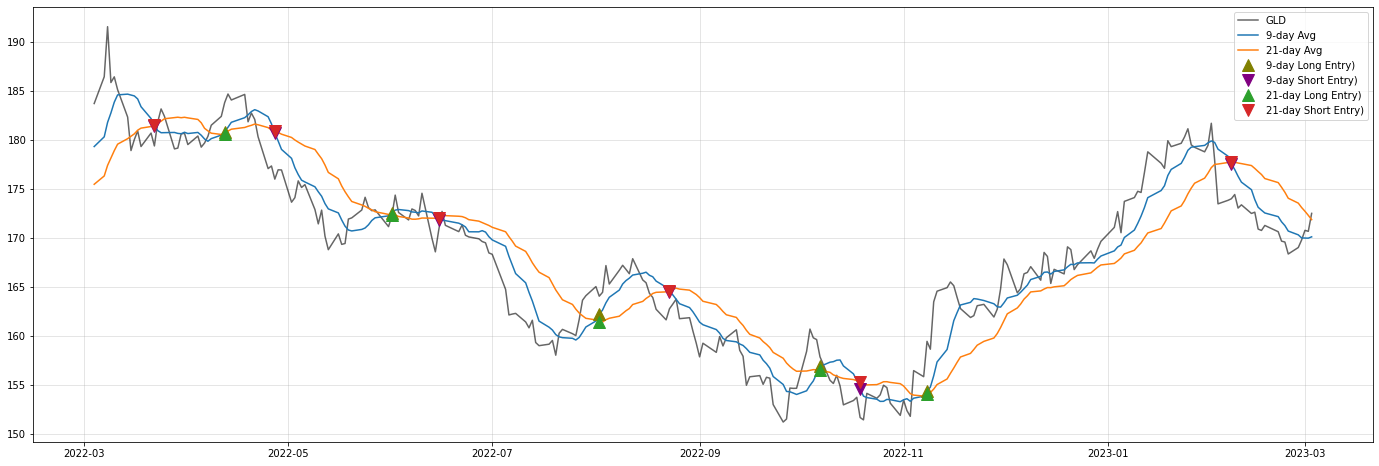

In [13]:
plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(df_2022['Close'], color='black', label = 'GLD', alpha=0.6)

plt.plot(df_2022['9-day'], label = '9-day Avg')
plt.plot(df_2022['21-day'], label = '21-day Avg')

plt.plot(df_2022.loc[df.entry == 2].index, df_2022['9-day'][df_2022.entry == 2], '^', color = 'olive', markersize = 12, label = '9-day Long Entry)')
plt.plot(df_2022.loc[df.entry == -2].index, df_2022['9-day'][df_2022.entry == -2], 'v', color = 'purple', markersize = 12, label = '9-day Short Entry)')

plt.plot(df_2022.loc[df.entry == 2].index, df_2022['21-day'][df_2022.entry == 2], '^', color = 'tab:green', markersize = 12, label = '21-day Long Entry)')
plt.plot(df_2022.loc[df.entry == -2].index, df_2022['21-day'][df_2022.entry == -2], 'v', color = 'tab:red', markersize = 12, label = '21-day Short Entry)')
plt.legend(loc='upper right');

## Calculate Instantaneous returns/system returns

In [14]:
df_2022['return'] = np.log(df_2022['Close']).diff()
df_2022['system_return'] = df_2022['signal'] * df_2022['return']

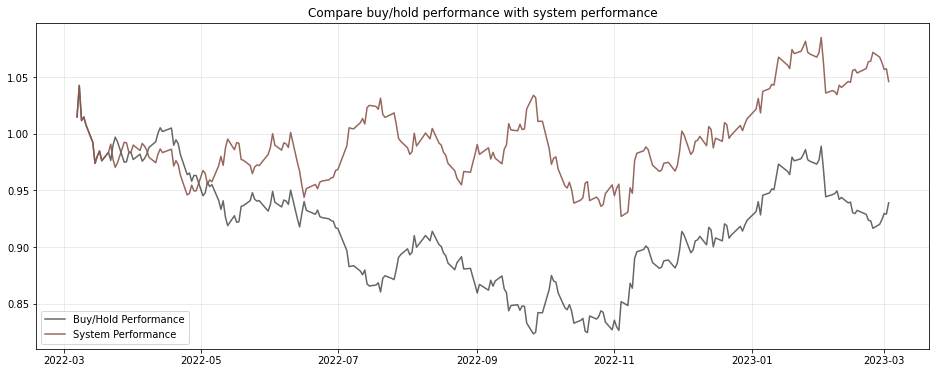

In [15]:
plt.grid(True, alpha=.3)
plt.plot(np.exp(df_2022['return']).cumprod(), color='black', alpha=0.6, label='Buy/Hold Performance')
plt.plot(np.exp(df_2022['system_return']).cumprod(), color='tab:brown', alpha=0.9, label='System Performance')
plt.title('Compare buy/hold performance with system performance')
plt.legend(loc='lower left');

Check Last day performance

In [16]:
np.exp(df_2022['return']).cumprod()

Date
2022-03-04         NaN
2022-03-07    1.014863
2022-03-08    1.042628
2022-03-09    1.011651
2022-03-10    1.014808
                ...   
2023-02-27    0.920133
2023-02-28    0.924325
2023-03-01    0.929660
2023-03-02    0.929116
2023-03-03    0.939079
Name: return, Length: 251, dtype: float64

In [17]:
np.exp(df_2022['return']).cumprod()[-1] - 1

-0.06092109989556127

In [18]:
np.exp(df_2022['system_return']).cumprod()[-1] - 1

0.04609595105792863